### Description - Modified XGBoost model by @titericz

XGBoost model created using @titericz model as reference. Instead of forecasting the monthly variation of "microbusiness_density" directly, we will forecast the monthly variation of "active" feature. This is because the population in each year is constante and when the year change, the population is atualized and the "microbusiness_density" change as well.

Another change in that we divide by classes of "active" and make a model to predict in each class.

### Libraries

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(8, 4),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

### 1. Basic Processing

In [4]:
train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
sub = pd.read_csv('./files/sample_submission.csv')
print(train.shape, test.shape, sub.shape)  # (122265, 7) (25080, 3) (25080, 2)


train['istest'] = 0
test['istest'] = 1
raw = (pd.concat((train, test))          # concat train and test data, and sort by cfips first, and then sort by row_id for each cfips
       .sort_values(['cfips','row_id'])  # since row_id has a format 'cfips-first day of month', basically we sort by time
       .reset_index(drop=True)           # because we have both train and test, the index is confounded. so we drop the index first and then give the joined table a new index from 0
      )

# set datetime format
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# complete the county for the test set data thas was concatenated
raw['county'] = (raw
                 .groupby('cfips')['county']
                 .ffill()
                )

# complete the state for the test set data thas was concatenated
raw['state'] = (raw
                .groupby('cfips')['state']
                .ffill()
               )

# set year and month to dataframe
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw['first_day_of_month'] = raw['first_day_of_month'].astype(str)

# set a value to each month
raw["dcount"] = (raw
                 .groupby(['cfips'])['row_id']
                 .cumcount()
                )

# attach a specific value to conty ans state
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw

(122265, 7) (25080, 3) (25080, 2)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50


#### 1.1 Economic rates (CPI and Treasury 10Y)

In [5]:
# load economic rates
econ_rates = pd.read_csv('./files/economic_rates.csv',
                         parse_dates=['first_day_of_month'],
                         index_col='first_day_of_month',
                        )

# map economic rates (cpi and treasury 10Y) into raw dataframe
raw = (raw
       .assign(cpi_monthly = raw['first_day_of_month'].map(econ_rates['cpi_monthly']),
               treasury10y = raw['first_day_of_month'].map(econ_rates['treasury10y']),
              )
      )

econ_rates.head(3)

,cpi_monthly,treasury10y
first_day_of_month,,
2019-08-01,0.1,2.007
2019-09-01,0.2,1.499
2019-10-01,0.3,1.668


In [6]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668


#### 1.2 Unemployment rate

In [7]:
unmp_rate = pd.read_csv('./files/state_unemployment.csv')

unmp_rate['id_map'] = (unmp_rate['first_day_of_month'] +'_' + unmp_rate['state'])
unmp_rate = unmp_rate.set_index('id_map')
unmp_rate.head(3)

,first_day_of_month,unemployment_rate,state
id_map,,,
2019-01-01_Alabama,2019-01-01,3.7,Alabama
2019-02-01_Alabama,2019-02-01,3.6,Alabama
2019-03-01_Alabama,2019-03-01,3.4,Alabama


In [8]:
# map the unemployment rate in each state
raw['pct_unemployment'] = (raw['first_day_of_month'] +'_' + raw['state']).map(unmp_rate['unemployment_rate'])
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0


#### 1.3 Population

In [9]:
def clean_popdf(df):
    # Change columns name
    df.columns = ['cfips', 'county', 'population2021']
    df['population2021'] = df['population2021'].astype(np.int64)
    df['cfips'] = df['cfips'].str.split('S', expand=True)[1]
    df['cfips'] = df['cfips'].astype(np.int64)
    df = df.set_index('cfips')
    
    return df

In [10]:
def map_pop(raw, pop_2021):
    
    raw['population'] = round(100 * raw['active'] / raw['microbusiness_density'], 0)
    raw['population'] = raw['population'].fillna(method="ffill").astype(np.int64)
    
    df = raw.loc[raw.dcount.isin([41,42,43,44,45,46])].copy()
    df['population'] = df['cfips'].map(pop_2021.to_dict()['population2021'])
    raw.loc[(raw.istest == 1) & (raw.year == 2023), 'population'] = df.loc[:, 'population']

    return raw

In [11]:
# load 2021 population data
pop_2021 = pd.read_csv('./files/ACSDP5Y2021.DP05-Data.csv',
                       usecols=['GEO_ID', 'NAME', 'DP05_0021E'],
                      ).drop(0, axis=0)


pop_2021 = clean_popdf(pop_2021)

raw = map_pop(raw, pop_2021)
raw.head(3)

C:\Users\DELL\AppData\Local\Temp\ipykernel_1944\3555398683.py:2: DtypeWarning: Columns (82) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_2021 = pd.read_csv('./files/ACSDP5Y2021.DP05-Data.csv',


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9,41527
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9,41527
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0,41527


### 2. Anomaly detection

In [12]:
lag = 1

# .shift(lag): for each cfips, shift its density column by lag=1, so the density in each first row will be NAN. -> you get a column with the length = len('density')
# .bfill(): fill NaN with the next valid density, so the density in each cfips' first row will be the original value, but note that
#           1001's density from 2022-12-01 to 2023-06-01 will be back filled by the first density of 1003 (the next cfips), in this new column 'mbd_lag_1'.
#           but, it turns out that doesn't really matter
# NOTE THAT, in the engineering, 'mbd_lag_1' is overwrite by new feature
# raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

raw[f'act_lag_{lag}'] = (raw
                     .groupby('cfips')['active']
                     .shift(lag)
                     .bfill()
                    )

# basically, 'dif' means the 'percentage increment' of the density from the previous month to this month
# raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

raw['act_var'] = (raw['active'] / raw[f'act_lag_{lag}']).fillna(1).clip(0, None) - 1

# if there are zeros in density, then we need to deal with special cases:
#    density  mbd_lag_1  div  fillna  clip  diff
#       1         1       1                 -> 0   
#       2         1       2                 -> 1
#       0         2       0                 -> -1
#       0         0      inf                -> inf     special cases
#       4         0      inf                -> inf     special cases
#      Nan        4      Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0

# --------------------------------------------
raw.loc[(raw[f'act_lag_{lag}']==0), 'act_var'] = 0
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0


raw.loc[(raw['active'] > 0) & (raw[f'act_lag_{lag}'] == 0), 'act_var'] = 1
# #    density  mbd_lag_1  div  fillna   diff
# #       1         1       1          -> 0   
# #       2         1       2          -> 1
# #       0         2       0          -> -1
# #       0         0      inf         -> inf     special cases -> 0
# #       4         0      inf         -> inf     special cases -> 0 -> 1   # is 1 a reasonable number?
# #      Nan        4      Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0

# # -------------------------

raw['act_var'] = raw['act_var'].abs()

In [13]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population,act_lag_1,act_var
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9,41527,1249.0,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9,41527,1249.0,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0,41527,1198.0,0.059265


#### Let's see which dcount (time point) has a SIGNIFICANT increase than the previous month!

We can see that the month of feb/2021 (dcount = 18) presents the biggest variation!


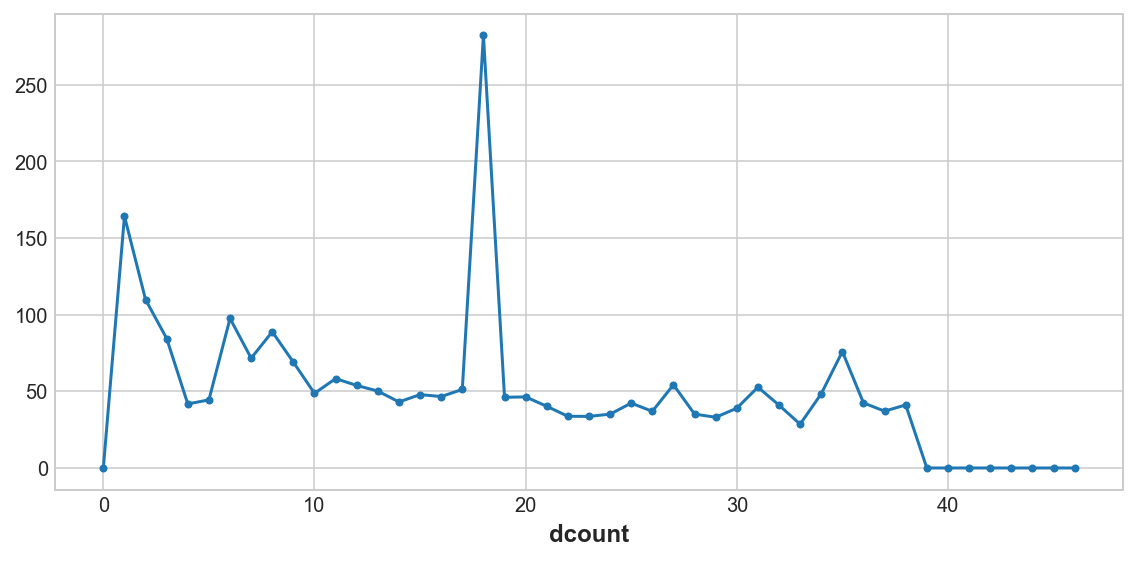

In [14]:
# raw.groupby('dcount')['dif'].sum().plot();
raw.groupby('dcount')['act_var'].sum().plot(style='.-');
print('We can see that the month of feb/2021 (dcount = 18) presents the biggest variation!')

### 3. Load cfips classes

In [15]:
def smoothing_outliers(raw):
    
    outliers = []   # record which cfips has outliners
    cnt = 0         # the tot num of outliners
    
    for cfip in raw.cfips.unique():                      # each cfips

        indices = (raw['cfips'] == cfip)                       # get all the idx for that cfips
        tmp = raw.loc[indices].copy().reset_index(drop=True)   # get all the rows for the cfips, reset_index make each tmp index from zero
        var = tmp['active'].values.copy()                      # copy density data for the current cfips
        #vmax = np.max(var[:38]) - np.min(var[:38])

        for i in range(37, 2, -1):                # idx 37 ~ 3. Note: 0 ~ 38 is training data
                                                  # why not consider 38? 2?  # i think you can even set it to 0
            thr = 0.20 * np.mean(var[:i])         # use 20% average of the points before current point i as the anomaly value TH
            difa = abs(var[i] - var[i-1])         # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend

            if (difa >= thr):                     # so we 'lift' all the previous values to the same 'stage' of the current point

                var[:i] *= ( var[i] / var[i-1] )
                outliers.append(cfip)             # save which cfips has outliers
                cnt += 1                          # total count

        # why not set the above for loop as range(37,0,-1)? so we don't need the line below
        var[0] = var[1] * 0.99               # why do this hard code 0.99? make the first -> second unchanged almost? 

        raw.loc[indices, 'active'] = var  # the smoothed density

    outliers = np.unique(outliers)
    len(outliers), cnt    
    
    return raw, outliers, cnt

#### 3.1 High & Extra High

In [16]:
# load dataset with cfips split in classes extra high and high, using "active" valua as threshold
high_extrahigh = pd.read_csv('./files/cfips_high-extrahigh_class.csv')

R2_dic = high_extrahigh.loc[:, ['cfips', 'R2_fev2021_forward']].set_index('cfips').to_dict()['R2_fev2021_forward']

high_extrahigh.head(3)

,cfips,active,class,R2_fev2021_forward
0,51510,26693.487179,high,0.989723
1,13151,12480.641026,high,0.989503
2,48257,4816.615385,high,0.988515


#### 3.1.1 Smoothing & Outlier correction

In [17]:
# filters the cfips
raw_high_extrahigh = raw.loc[raw.cfips.isin(high_extrahigh.cfips)].reset_index(drop=True).copy()

# treat outliers
raw_high_extrahigh, outliers, noutliers = smoothing_outliers(raw_high_extrahigh)

# mapping R2 error
raw_high_extrahigh['R2_error'] = raw_high_extrahigh.cfips.map(R2_dic)

print('outliers: \n', list(outliers))
print('\nnumber operations smoothing: ', noutliers)

outliers: 
 [1125, 8014, 8031, 8069, 8105, 10003, 10005, 12001, 12131, 17037, 18039, 28071, 32510, 34005, 34021, 37175, 46099, 51085, 51710, 53073, 56033]

number operations smoothing:  47


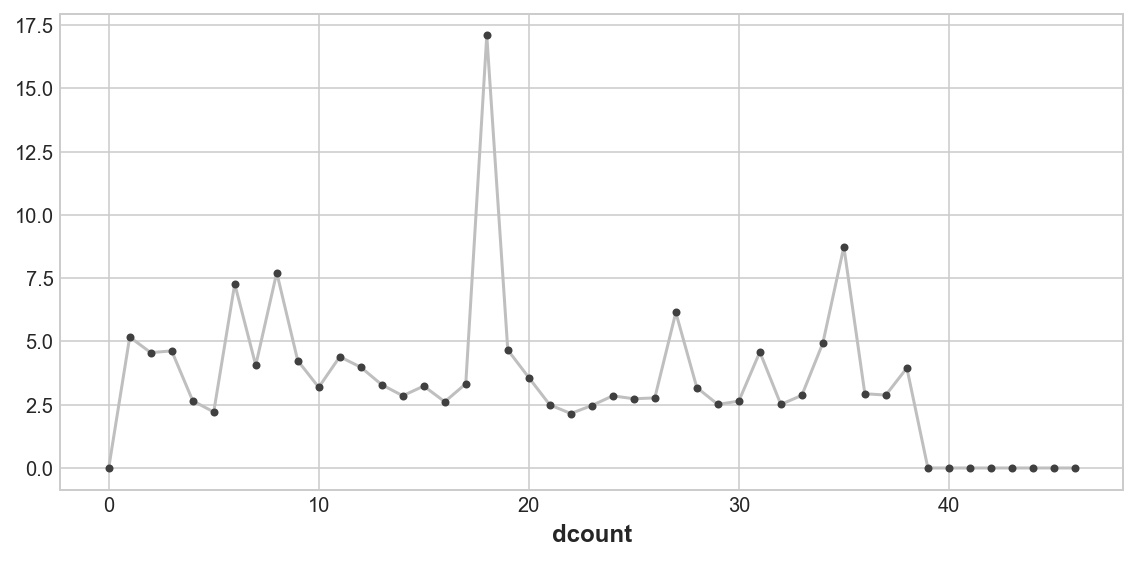

In [18]:
# Do the steps earlier again
lag = 1

raw_high_extrahigh.loc[:, f'act_lag_{lag}'] = raw_high_extrahigh.groupby('cfips')['active'].shift(lag).bfill()
raw_high_extrahigh['act_var'] = (raw_high_extrahigh['active'] / raw_high_extrahigh[f'act_lag_{lag}']).fillna(1).clip(0, None) - 1
raw_high_extrahigh.loc[(raw_high_extrahigh[f'act_lag_{lag}'] == 0), 'act_var'] = 0
raw_high_extrahigh.loc[(raw_high_extrahigh['active'] > 0) & (raw_high_extrahigh[f'act_lag_{lag}'] == 0), 'act_var'] = 1
raw_high_extrahigh['act_var'] = raw_high_extrahigh['act_var'].abs().copy()

# Plot
raw_high_extrahigh.groupby('dcount')['act_var'].sum().plot(**plot_params);

In [19]:
# raw_high_extrahigh.loc[raw_high_extrahigh.cfips==1125]

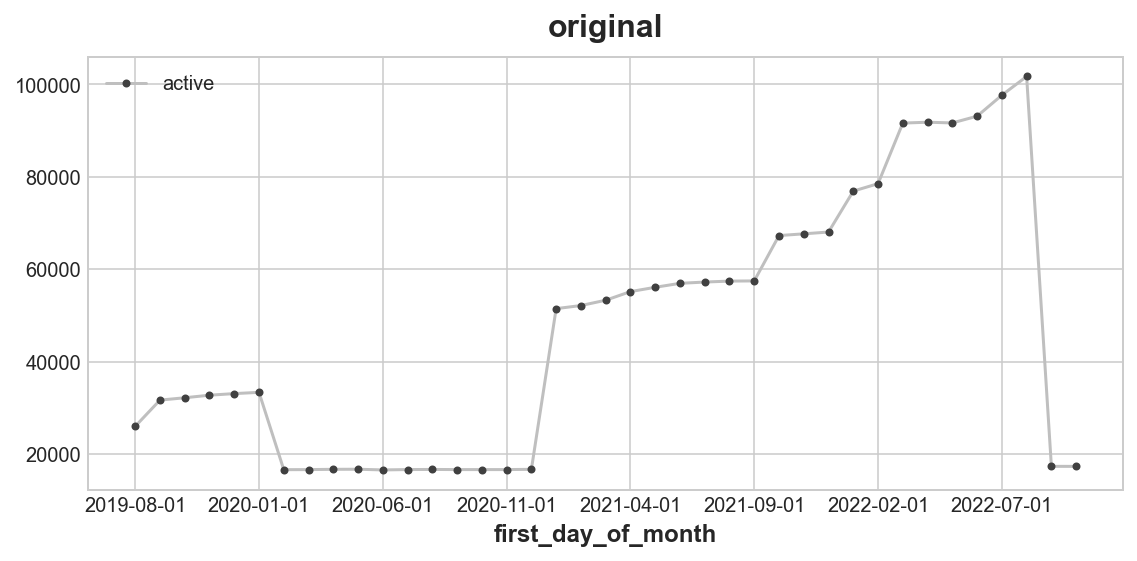

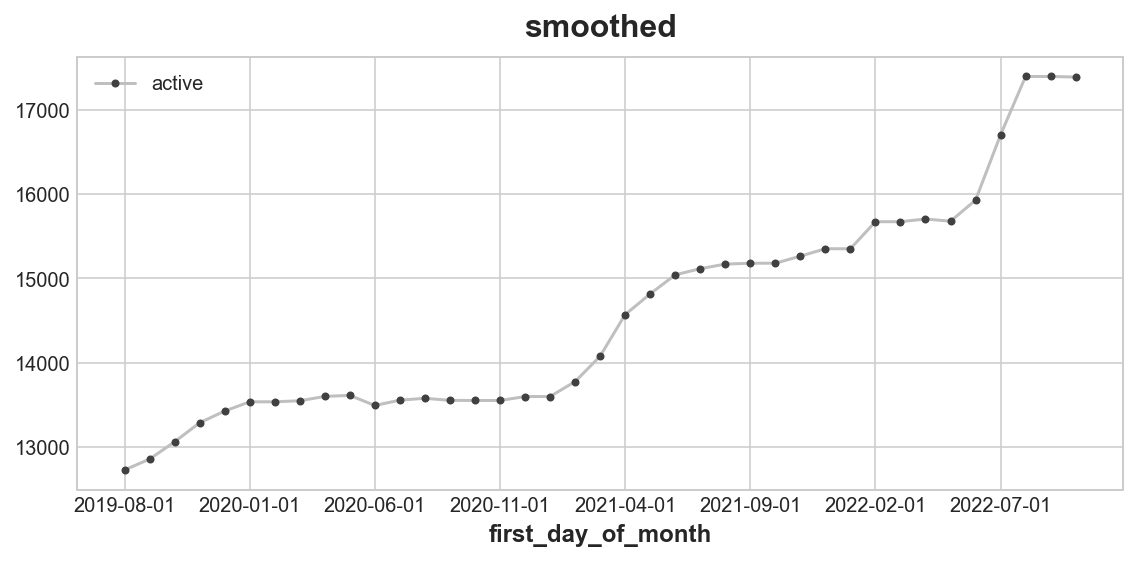

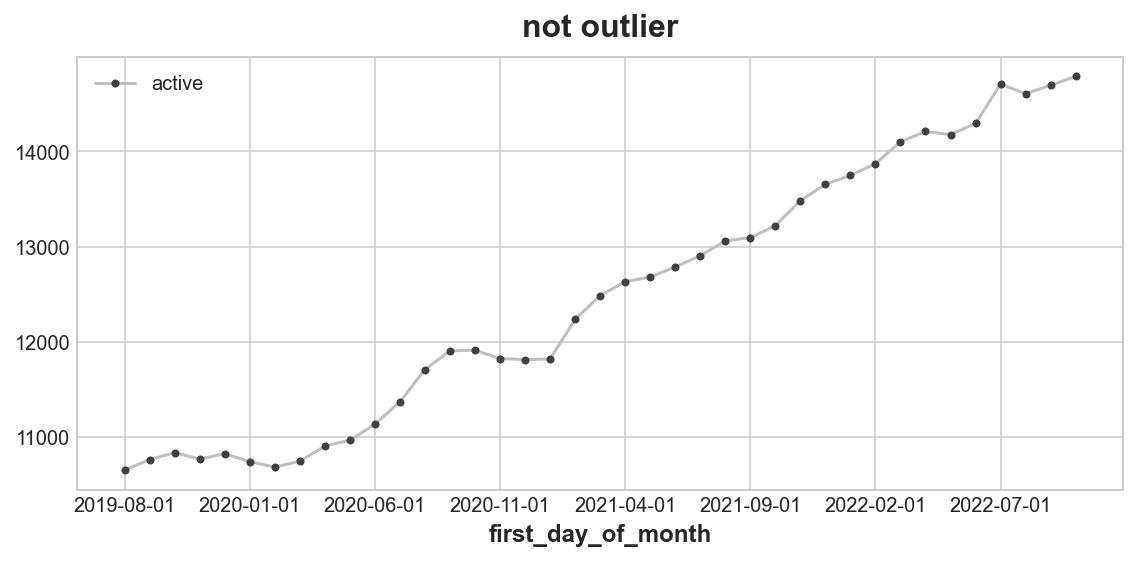

In [20]:
# plot two cfips density change over time
raw.loc[raw.cfips == 12001].plot(x='first_day_of_month', y='active', **plot_params, title='original')
raw_high_extrahigh.loc[raw_high_extrahigh.cfips == 12001].plot(x='first_day_of_month', y='active', **plot_params, title='smoothed')
raw_high_extrahigh.loc[raw_high_extrahigh.cfips == 13151].plot(x='first_day_of_month', y='active', **plot_params, title='not outlier');

#### 3.1.2 Define target (SMAPE relative metric)

In [21]:
def set_target(raw):
    raw['target'] = raw.groupby('cfips')['active'].shift(-1)    # shift UP
    raw['target'] = raw['target'] / raw['active'] - 1           # next / this month - 1 = the next month increment
                                                                # NOTE: dcount = 38 doesn't have target value - not next month
                                                                # to compare 
    return raw

In [22]:
# Define targets
raw_high_extrahigh = set_target(raw_high_extrahigh)
                                                           
# two special cases, hard code to 0.0
# raw.loc[raw['cfips'] == 28055, 'target'] = 0.0
# raw.loc[raw['cfips'] == 48269, 'target'] = 0.0

In [23]:
raw_high_extrahigh.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population,act_lag_1,act_var,R2_error,target
0,1003_2019-08-01,1003,Baldwin County,Alabama,2019-08-01,7.239156,11430.54,0,2019,8,...,1,0,0.1,2.007,2.9,158361,11430.54,0.000000,0.579484,0.010101
1,1003_2019-09-01,1003,Baldwin County,Alabama,2019-09-01,7.290936,11546.00,0,2019,9,...,1,0,0.2,1.499,2.9,158361,11430.54,0.010101,0.579484,0.018448
2,1003_2019-10-01,1003,Baldwin County,Alabama,2019-10-01,7.425439,11759.00,0,2019,10,...,1,0,0.3,1.668,3.0,158361,11546.00,0.018448,0.579484,0.000085


In [24]:
print(raw_high_extrahigh.target.median(), raw_high_extrahigh.target.mean(), raw_high_extrahigh.target.std())
len(raw_high_extrahigh.loc[(raw_high_extrahigh.target >= -0.008) & (raw_high_extrahigh.target <= 0.008)])

0.0021653543307087464 0.0024720195479169195 0.016231211864799748


13307

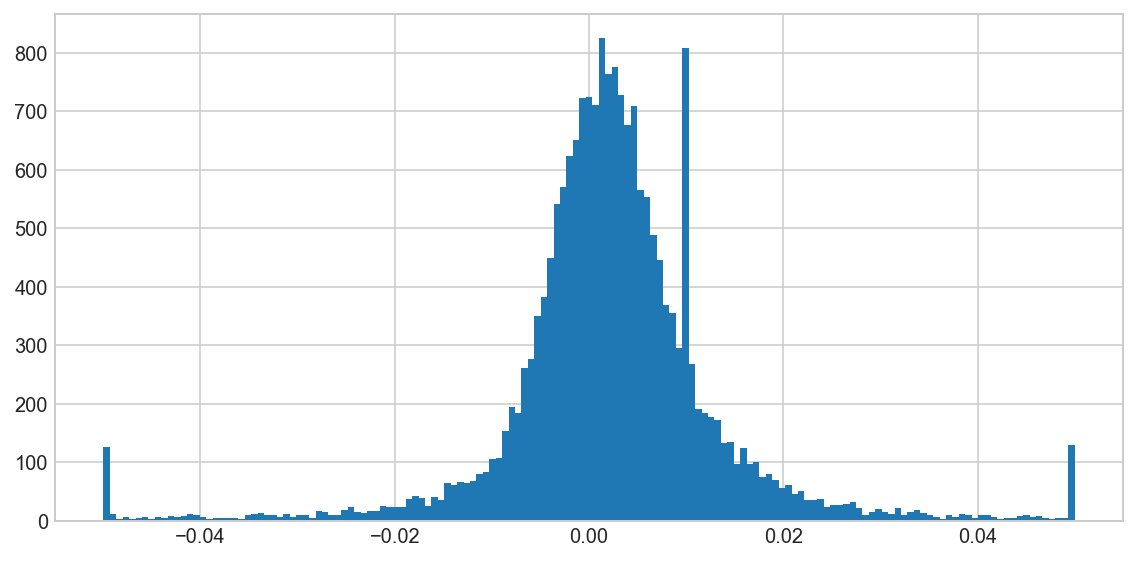

In [25]:
raw_high_extrahigh['target'].clip(-0.05, 0.05).hist(bins=151);

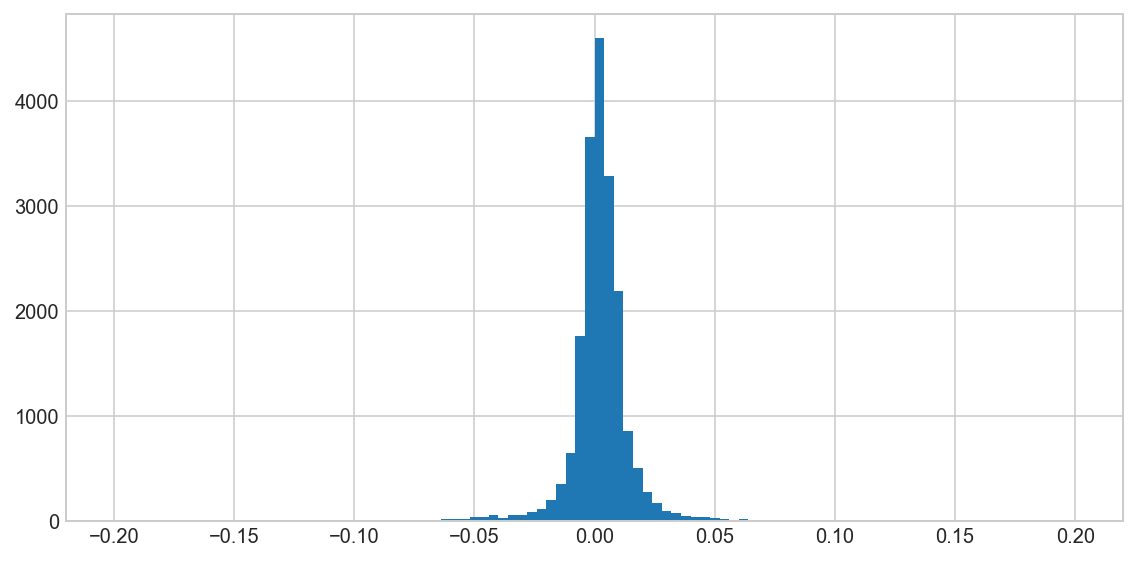

In [26]:
raw_high_extrahigh['target'].clip(-0.2, 0.2).hist(bins=100);

#### 3.1.3 Define last_target and last_mbd

In [27]:
def last_target_mbd(raw):
    
    # for each cfips, get the last active value and assign it to the NEW column 'lastactive'
    raw['last_mbd'] = (raw
                       .groupby('cfips')['microbusiness_density']
                       .transform('last')
                      )

    # mapping dataframe
    dt = (raw
          .loc[raw.dcount == 28]
          .groupby('cfips')['active']
          .agg('last')
         )

    # basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
    # NOTE: this is the actual density value! not the target value. why 28?
    raw['last_target'] = raw['cfips'].map(dt)

    return raw

In [28]:
# create the columns last_target and last_mbd
raw_high_extrahigh = last_target_mbd(raw_high_extrahigh)


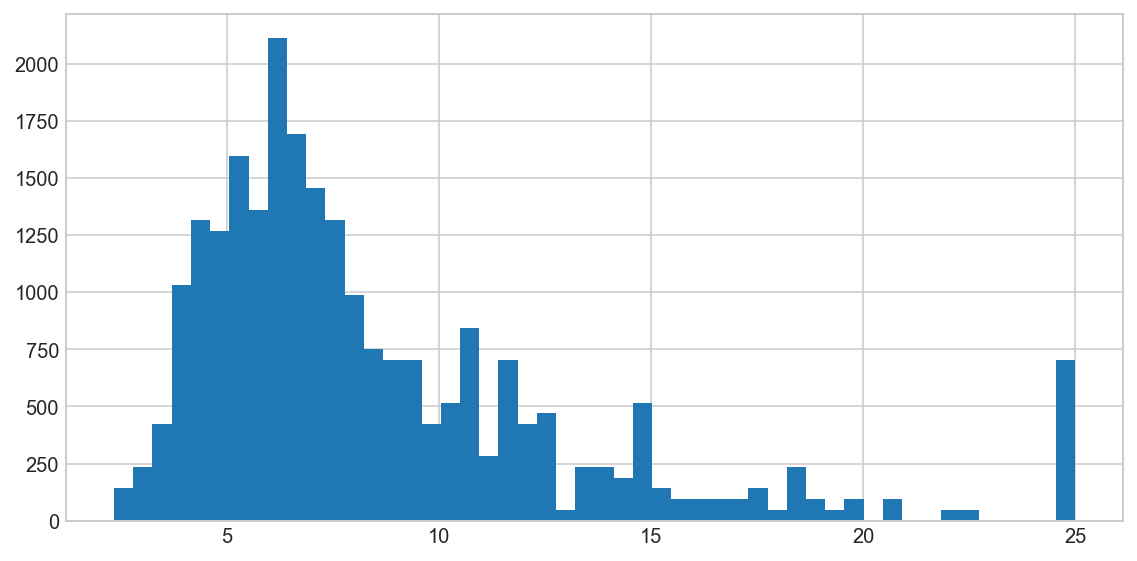

In [29]:
raw_high_extrahigh['last_mbd'].clip(0, 25).hist(bins=50);

In [30]:
raw_high_extrahigh.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,cpi_monthly,treasury10y,pct_unemployment,population,act_lag_1,act_var,R2_error,target,last_mbd,last_target
0,1003_2019-08-01,1003,Baldwin County,Alabama,2019-08-01,7.239156,11430.54,0,2019,8,...,0.1,2.007,2.9,158361,11430.54,0.000000,0.579484,0.010101,8.359798,13211.0
1,1003_2019-09-01,1003,Baldwin County,Alabama,2019-09-01,7.290936,11546.00,0,2019,9,...,0.2,1.499,2.9,158361,11430.54,0.010101,0.579484,0.018448,8.359798,13211.0
2,1003_2019-10-01,1003,Baldwin County,Alabama,2019-10-01,7.425439,11759.00,0,2019,10,...,0.3,1.668,3.0,158361,11546.00,0.018448,0.579484,0.000085,8.359798,13211.0


### 4. Feature Engineering

In [31]:
def build_features(raw, target='active', target_mbd='microbusiness_density', lags = 6):
    '''
    e.g.,
    target = 'target'
    target_act = 'microbusiness_density'
    lags = 4
    '''
    
    feats = []
    for lag in range(1, lags):  # 1 ~ 3
        
        # for each cfips, shift the 'target' column by 1,2 and 3
        # the original 'target' column has values from 0 to 37, note that dcount = 38 (2022-10-01) doesn't have a target value 
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        
        # for each cfips, the diff between the current avtive value and the previous 1,2,and 3 months' active values
        # the original 'active' column has values from 0 to 38
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target_mbd].diff(lag)
        
        # the shifted 'target' and 'active' are taken as features
        # basically, for each month, the previous 1,2,3 months' target and active are taken into consideration
        feats.append(f'act_lag_{lag}')
        feats.append(f'mbd_lag_{lag}')
    
    # the sum of the previous 2,4,6 months 'target' value
    lag = 1
    for window in [2, 4, 6]:
        raw[f'act_rollsum{window}_{lag}'] = (raw
                                             .groupby('cfips')[f'act_lag_{lag}']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )
        
        feats.append(f'act_rollsum{window}_{lag}')
        
    for window in [3, 4, 5]:
        raw[f'act_rollstd{window}_{lag}'] = (raw
                                             .groupby('cfips')[f'act_lag_{lag}']
                                             .transform(lambda s: s.rolling(window, min_periods=1).std())
                                            )
        
        feats.append(f'act_rollstd{window}_{lag}')
        
    for window in [1, 2, 3]:
        raw[f'cpi_rollsum{window}_{lag}'] = (raw
                                             .groupby('cfips')['cpi_monthly']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )

        
        feats.append(f'cpi_rollsum{window}_{lag}')
    
#     for window in [2, 4, 6]:
#         raw[f'unmp_rollsum{window}_{lag}'] = (raw
#                                              .groupby('cfips')['pct_unemployment']
#                                              .transform(lambda s: s.rolling(window, min_periods=1).sum())
#                                             )


#         feats.append(f'unmp_rollsum{window}_{lag}')

        
    return raw, feats

In [32]:
# Build Features based in lag of target
raw_high_extrahigh, feats = build_features(raw_high_extrahigh, 'target', 'microbusiness_density', lags = 4)

# the state code is a feature
features = ['state_i', 'R2_error']
features += feats
print(features)

raw_high_extrahigh.loc[raw_high_extrahigh.dcount == 38, features].head(10)

['state_i', 'R2_error', 'act_lag_1', 'mbd_lag_1', 'act_lag_2', 'mbd_lag_2', 'act_lag_3', 'mbd_lag_3', 'act_rollsum2_1', 'act_rollsum4_1', 'act_rollsum6_1', 'act_rollstd3_1', 'act_rollstd4_1', 'act_rollstd5_1', 'cpi_rollsum1_1', 'cpi_rollsum2_1', 'cpi_rollsum3_1']


,state_i,R2_error,act_lag_1,mbd_lag_1,act_lag_2,mbd_lag_2,act_lag_3,mbd_lag_3,act_rollsum2_1,act_rollsum4_1,act_rollsum6_1,act_rollstd3_1,act_rollstd4_1,act_rollstd5_1,cpi_rollsum1_1,cpi_rollsum2_1,cpi_rollsum3_1
38,0,0.579484,0.002170,0.018098,-0.017601,-0.131351,-0.009601,-0.213665,-0.015431,-0.017278,0.049618,0.009945,0.011433,0.037214,0.4,0.8,0.9
85,0,0.862591,0.004464,0.028922,0.001764,0.040334,-0.002064,0.026955,0.006228,0.019858,0.012887,0.003280,0.007638,0.006825,0.4,0.8,0.9
132,0,0.819732,0.004252,0.017064,0.006223,0.041883,-0.005031,0.021717,0.010475,0.025780,0.031552,0.006010,0.010480,0.009090,0.4,0.8,0.9
179,0,0.891233,0.005798,0.037930,0.001759,0.049414,-0.001330,0.040714,0.007557,0.024489,0.021910,0.003575,0.008604,0.007600,0.4,0.8,0.9
226,0,0.759759,-0.000154,-0.000631,0.004088,0.016099,0.018619,0.090911,0.003934,0.045949,0.047501,0.009845,0.011298,0.010145,0.4,0.8,0.9
273,0,0.660891,-0.005760,-0.027709,0.007009,0.005772,-0.008626,-0.035791,0.001249,0.002789,-0.004551,0.008324,0.009276,0.008135,0.4,0.8,0.9
320,0,0.946199,0.002986,0.022341,0.007071,0.074872,-0.001299,0.065211,0.010057,0.029048,0.037824,0.004185,0.009333,0.008129,0.4,0.8,0.9
367,0,0.286573,0.022118,0.088438,0.014602,0.145984,0.002620,0.156281,0.036720,0.060265,0.068703,0.009834,0.008929,0.007930,0.4,0.8,0.9
414,1,0.890912,0.000066,0.000452,0.001989,0.014015,-0.001853,0.001356,0.002055,0.016753,0.016555,0.001921,0.008390,0.007352,0.4,0.8,0.9
461,2,0.800816,0.002756,0.016782,0.007746,0.063596,0.000585,0.067130,0.010502,0.030619,0.040272,0.003672,0.008467,0.007512,0.4,0.8,0.9


In [33]:
# raw_high_extrahigh.loc[raw_high_extrahigh.dcount == 38, features].state_i.value_counts()

### 5. Model

In [34]:
# cfips that prediction is worse than last value
blacklistcfips_high_extrahigh = [
1101,4013,6033,8105,10003,12017,12127,13117,15007,17167,18019,18127,22103,27037,29019,32005,32510,35049,36055,36067,40027,
42011,42019,42071,44009,46099,50003,50027,51810,53033,55025,55127,55131, 1097,1125,4021,4025,6053,6057,6071,6081,6087,6089,
8013,8069,9007,9009,12001,12009,12019,12099,13067,13077,13121,13139,13245,13247,16001,17031,17037,17113,17143,18003,18039,
19013,19101,19113,20177,22019,24013,24027,24031,25015,26065,26161,27109,28049,28071,29183,33015,34017,34021,34035,34039,36047,
36061,36081,36091,36103,37021,37175,39017,39025,39049,39057,39113,39153,41017,41033,41051,41061,42125,44003,44005,44007,47163,
48355,48367,48397,51059,51177,51710,53057,55087,55101,56021,56039,12095,13157,28089,36059,
]


In [ ]:
# raw_high_extrahigh.loc[raw_high_extrahigh.cfips==3934].head(50)

In [39]:
# threshold
# ACT_THR = 18
ABS_THR = 0.0

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.0

VAL = []
BEST_ROUNDS = []

In [38]:
# raw_high_extrahigh.iloc[:50, :15]

In [41]:
for TS in range(29, 38):  # from 29 to 37.  1) is it the reason why 'lasttarget' use 'dcount=28'?  
                          # the actual density pred you give is 30 to 38  
    print(TS)
    
    # --- define the model
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',   # why this objective?
        #objective='reg:squarederror',
        max_depth=6,                        # max depth of a tree
        tree_method="hist",                 # 
        n_estimators=4999,                  # iterations
        learning_rate=0.0075,
        max_leaves=17,    
        subsample=0.50,                     # sample used for each iteration
        colsample_bytree=0.50,              # features used for each iteration
        max_bin=4096,                       # 
        n_jobs=2,
        reg_lambda=1,                       # L2 regularization
        reg_alpha=0,                        # L1 regularization
        eval_metric='mae',                  # 
        early_stopping_rounds=70,
    )
    
    # --- get training data
    train_indices = (raw_high_extrahigh.istest == 0) & \
                    (raw_high_extrahigh.dcount < TS) & \
                    (raw_high_extrahigh.dcount >= 18) & \
                    (raw_high_extrahigh.last_mbd > ABS_THR) 
                # & (raw_high_extrahigh.last_target > ACT_THR)
    
    # --- get validation data
    valid_indices = (raw_high_extrahigh.istest == 0) & \
                    (raw_high_extrahigh.dcount == TS)
    
    # --- model fit
    model.fit(
        raw_high_extrahigh.loc[train_indices, features],
        raw_high_extrahigh.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw_high_extrahigh.loc[valid_indices, features], raw_high_extrahigh.loc[valid_indices, 'target'])],
        verbose=500,
    )
    
    # --- save best iteration
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    
    # --- pred the current validation set, note the pred is the increment comparing to TS+1
    ypred = model.predict(raw_high_extrahigh.loc[valid_indices, features])
    
    # --- ACTUALLY, WE ARE PREDICTING **TS+1** ---
    # becasue we pred the increment for the next month, so we need to add 1
    raw_high_extrahigh.loc[valid_indices, 'k'] = ypred + 1
    # if you multiple it with 'density' in TS, you get next month TS+1 density prediction
    raw_high_extrahigh.loc[valid_indices, 'k'] = raw_high_extrahigh.loc[valid_indices,'k'] * \
                                                 raw_high_extrahigh.loc[valid_indices,'active']

    
    # mapping last values
    lastval = (raw_high_extrahigh
               .loc[raw_high_extrahigh.dcount == TS, ['cfips', 'active']]
               .set_index('cfips')
               .to_dict()['active']
              )
    
    # mapping prediction made
    dt = (raw_high_extrahigh
          .loc[raw_high_extrahigh.dcount == TS, ['cfips', 'k']]
          .set_index('cfips')
          .to_dict()['k']
         )
    
    # define a temporary dataframe for the preds of TS+1
    df = (raw_high_extrahigh
          .loc[raw_high_extrahigh.dcount == (TS+1), ['cfips', 'active', 'state', 'last_mbd', 'act_lag_1']]
          .reset_index(drop=True)
         )
    
    # ATTACH the mappings to df columns
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    # FOR SOME CASES, WE DON'T WANT TO USE THE PREDICTIONS BY THE MODEL, INSTEAD, WE WANT TO USE THE TS DENSITY.
    # case1. for each cfips, if the last active in dcount=38 is smaller than ACT_THR, (which means the business scale is considered as small)
    #    then, we don't use the pred above, instead, use the TS density
#     df.loc[df['last_mbd'] <= ABS_THR, 'pred'] = df.loc[df['last_mbd'] <= ABS_THR, 'lastval']
    
    # case2. for each cfips, if the TS actual density is smaller than ABS_THR, (which means the recent trend is small?)
    #    then, we don't use the pred above, instead, use the TS density
#     df.loc[df['lastval'] <= ACT_THR, 'pred'] = df.loc[df['lastval'] <= ACT_THR, 'lastval']
    
    # case3. if the state is in the black list, then we don't use the pred above, instead, use the TS density
    #        how to get this blacklist?
#     df.loc[df['state'].isin(blacklist_new), 'pred'] = df.loc[df['state'].isin(blacklist_new), 'lastval']
    
    # case4. if the cfips is in the black list, then we don't use the pred above, instead, use the TS density
    df.loc[df['cfips'].isin(blacklistcfips_high_extrahigh), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips_high_extrahigh), 'lastval']
    
    # FINALLY, assign the pred to the 'ypred' column of the 'raw_high_extrahigh' dataframe
    raw_high_extrahigh.loc[raw_high_extrahigh.dcount == (TS+1), 'ypred'] = df['pred'].values
    #          lastval is the actual density in TS, basically, you shift lag=1
    raw_high_extrahigh.loc[raw_high_extrahigh.dcount == (TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['active'], df['lastval']) )   # smape if you simply use last density to predict TS+1
    print('XGB SMAPE:', smape(df['active'], df['pred']))              # smape if you use the preds
    print()

ind = (raw_high_extrahigh.dcount >= 30) & (raw_high_extrahigh.dcount <= 38)
print( 'XGB SMAPE:', smape( raw_high_extrahigh.loc[ind, 'active'],  raw_high_extrahigh.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw_high_extrahigh.loc[ind, 'active'],  raw_high_extrahigh.loc[ind, 'ypred_last'] ) )

29
[0]	validation_0-mae:0.49266
[500]	validation_0-mae:0.01035
[823]	validation_0-mae:0.00460
TS: 29
Last Value SMAPE: 0.5132651283356937
XGB SMAPE: 0.44488570132134864

30
[0]	validation_0-mae:0.48691
[500]	validation_0-mae:0.00628
[654]	validation_0-mae:0.00498
TS: 30
Last Value SMAPE: 0.8883933870599505
XGB SMAPE: 0.4994874499105363

31
[0]	validation_0-mae:0.49217
[500]	validation_0-mae:0.01056
[1000]	validation_0-mae:0.00413
[1117]	validation_0-mae:0.00413
TS: 31
Last Value SMAPE: 0.4875623788597356
XGB SMAPE: 0.40745402067112935

32
[0]	validation_0-mae:0.50064
[500]	validation_0-mae:0.01679
[1000]	validation_0-mae:0.00657
[1500]	validation_0-mae:0.00628
[1778]	validation_0-mae:0.00627
TS: 32
Last Value SMAPE: 0.5629251649762985
XGB SMAPE: 0.6223320815234974

33
[0]	validation_0-mae:0.48762
[500]	validation_0-mae:0.00854
[664]	validation_0-mae:0.00716
TS: 33
Last Value SMAPE: 0.9553317341573095
XGB SMAPE: 0.6586121631746861

34
[0]	validation_0-mae:0.47875
[500]	validation_0-mae:

In [ ]:
raw_high_extrahigh['error'] = vsmape(raw_high_extrahigh['active'], raw_high_extrahigh['ypred'])
raw_high_extrahigh['error_last'] = vsmape(raw_high_extrahigh['active'], raw_high_extrahigh['ypred_last'])
raw_high_extrahigh.loc[(raw_high_extrahigh.dcount==30), ['cfips', 'active', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

In [ ]:
# select pred indices
ind = (raw_high_extrahigh.dcount >= 30) & (raw_high_extrahigh.dcount <= 38)

# calculate microbusiness_density using the "active" predicted
raw_high_extrahigh['mbd_pred'] = 100 * raw_high_extrahigh['ypred'] / raw_high_extrahigh['population']
raw_high_extrahigh['mbd_last'] = 100 * raw_high_extrahigh['ypred_last'] / raw_high_extrahigh['population']

# As we scaled the "active" feature, we as have to scale the "microbusiness_density"
raw_high_extrahigh['mbd_orig_scaled'] = 100 * raw_high_extrahigh['active'] / raw_high_extrahigh['population']

print( 'XGB SMAPE (mbd):', smape( raw_high_extrahigh.loc[ind, 'mbd_orig_scaled'],  raw_high_extrahigh.loc[ind, 'mbd_pred'] ) )
print( 'Last Value SMAPE (mbd):', smape( raw_high_extrahigh.loc[ind, 'mbd_orig_scaled'],  raw_high_extrahigh.loc[ind, 'mbd_last'] ) )

In [ ]:
# raw_high_extrahigh.head(50)

### 6. Some post-hoc analysis after training and validation

#### 6.1 which state has the most significant diff between the error (by pred) and the error_last (by last value pred)

for example, it is better to use the actual xgb prediction for the district of columbia, instead of the last prediction.

In [ ]:
dt = raw_high_extrahigh.loc[(raw_high_extrahigh.dcount>=30) & (raw_high_extrahigh.dcount<=38)].groupby('state')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt

#### 6.2 which month has the biggest error

In [ ]:
dt = raw_high_extrahigh.loc[(raw_high_extrahigh.dcount >= 30) & (raw_high_extrahigh.dcount <= 38)].groupby('dcount')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt.loc[dt['hit'] > 0]
dt

In [ ]:
dt = raw_high_extrahigh.loc[(raw_high_extrahigh.dcount == 33), ['cfips', 'error', 'error_last']].set_index('cfips')
dt['dif'] = dt.error - dt.error_last
dt = dt.sort_values('dif', ascending=False)
worse33 = dt.index[:50]
display(dt.head())
dt.dif.clip(None, 0.3).hist(bins=101);

In [ ]:
raw_high_extrahigh.groupby('dcount')['microbusiness_density'].mean().plot(**plot_params)

#### 6.3 Counties with the biggest mean errors across all prediction period

In [ ]:
dt = raw_high_extrahigh.loc[(raw_high_extrahigh.dcount >= 30) & (raw_high_extrahigh.dcount <= 38)].groupby(['state','cfips'])[['ypred','error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit'] > 0]
dt = dt.reset_index()
dt
# dt.hit.clip(None, -0.13).hist(bins=100)

In [ ]:
print('cfips in black list states: ')
len(raw_high_extrahigh.loc[raw_high_extrahigh.state.isin(['New Mexico', 'Rhode Island', 'North Dakota', 'Vermont']), 'cfips'].unique())

In [ ]:
# list of cfips that does worse than xgboost
dt = dt.sort_values('cfips')
','.join([str(i) for i in dt.cfips.values])

In [ ]:
dt.ypred.clip(0, 5000).hist(bins=100)
# plt.xlim(0, )

In [ ]:
dt.cfips.values.shape

In [ ]:
# show me the preds, WHY WHERE IS A LAG?????
for d in worse33: #blacklistcfips_high_extrahigh:
    raw_high_extrahigh.loc[raw_high_extrahigh.cfips==d].plot(x='dcount', y=['microbusiness_density', 'mbd_pred'], title=str(d), style='.-')
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

#### 6.4 Counties that were best in each prediction

In [ ]:
dt = raw_high_extrahigh.loc[(raw_high_extrahigh.dcount >= 30) & (raw_high_extrahigh.dcount <= 38), ['cfips', 'error', 'error_last']]
dt['it_best'] = dt.error < dt.error_last
dt = dt.groupby('cfips')[['it_best']].sum().sort_values('it_best', ascending=False)
dt.value_counts()
# dt.loc[dt.it_best.isin([0,1,2,3,4])].index

In [ ]:
lista = list(set(dt.loc[dt.it_best.isin([0,1,2,3,4,5])].index) - set(blacklistcfips_high_extrahigh))
lista.sort()
','.join([str(i) for i in lista])

### 7. LET'S GET THE PREDICTIONS FOR TS=38+1, WHICH IS 2022-11-01

In [ ]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

In [ ]:
best_rounds = 1200 #int(np.median( BEST_ROUNDS ) + 1)
best_rounds

In [ ]:
TS = 38  #29
print('TS: ', TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves =31,           # the model used above has 17
    subsample=0.6,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
    #early_stopping_rounds=70,
)

model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves =31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
    #early_stopping_rounds=70,
)

train_indices = (raw_high_extrahigh.istest == 0) & \
                (raw_high_extrahigh.dcount < TS) & \
                (raw_high_extrahigh.dcount >= 1) & \
                (raw_high_extrahigh.last_mbd > ABS_THR) #& 
                #(raw_high_extrahigh.last_target > ACT_THR)

valid_indices = (raw_high_extrahigh.dcount == TS)

# I don't understand why we need two identical models. and then do a half / half ensemble
print("model0:")
model0.fit(
    raw_high_extrahigh.loc[train_indices, features],
    raw_high_extrahigh.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
    #eval_set=[(raw_high_extrahigh.loc[valid_indices, features], raw_high_extrahigh.loc[valid_indices, 'target'])],
    #verbose=250,
)


print("model1:")
model1.fit(
    raw_high_extrahigh.loc[train_indices, features],
    raw_high_extrahigh.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
    #eval_set=[(raw_high_extrahigh.loc[valid_indices, features], raw_high_extrahigh.loc[valid_indices, 'target'])],
    #verbose=250,
)

ypred = (model0.predict(raw_high_extrahigh.loc[valid_indices, features]) + \
         model1.predict(raw_high_extrahigh.loc[valid_indices, features])) / 2

raw_high_extrahigh.loc[valid_indices, 'k'] = ypred + 1.0
raw_high_extrahigh.loc[valid_indices,'k'] = raw_high_extrahigh.loc[valid_indices,'k'] * raw_high_extrahigh.loc[valid_indices,'active']

# 1. define two mappings, lastval and dt
lastval = (raw_high_extrahigh
           .loc[raw_high_extrahigh.dcount == TS, ['cfips', 'active']]
           .set_index('cfips')
           .to_dict()['active']
          )

dt = (raw_high_extrahigh
      .loc[raw_high_extrahigh.dcount == TS, ['cfips', 'k']]
      .set_index('cfips')
      .to_dict()['k']
     )

# 2. define a temporary dataframe for the preds of TS+1
df = (raw_high_extrahigh
      .loc[raw_high_extrahigh.dcount == (TS+1), ['cfips', 'active', 'state', 'last_mbd', 'act_lag_1']]
      .reset_index(drop=True)
     )

# ATTACH the mappings to df columns
df['pred'] = df['cfips'].map(dt)            # put TS+1 density pred to 'pred' column of the TS+1 specific df
df['lastval'] = df['cfips'].map(lastval)    # put the TS density to 'lastval' column of df

# special cases when last_value s better than xgboos prediction
# df.loc[df['last_mbd'] <= ABS_THR, 'pred'] = df.loc[df['last_mbd'] <= ABS_THR, 'lastval']
# df.loc[df['lastval'] <= ACT_THR, 'pred'] = df.loc[df['lastval'] <= ACT_THR, 'lastval']
# df.loc[df['state'].isin(blacklist_new), 'pred'] = df.loc[df['state'].isin(blacklist_new), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips_high_extrahigh), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips_high_extrahigh), 'lastval']


# FINALLY, assign the pred to the 'ypred' column of the 'raw_high_extrahigh' dataframe
raw_high_extrahigh.loc[raw_high_extrahigh.dcount == (TS+1), 'ypred'] = df['pred'].values
raw_high_extrahigh.loc[raw_high_extrahigh.dcount == (TS+1), 'ypred_last'] = df['lastval'].values

# special cases
raw_high_extrahigh.loc[(raw_high_extrahigh['cfips'] == 28055) & (raw_high_extrahigh.dcount == 39), 'ypred'] = 0
raw_high_extrahigh.loc[(raw_high_extrahigh['cfips'] == 48269) & (raw_high_extrahigh.dcount == 39), 'ypred'] = 4

# calculate microbusiness_density using the "active" predicted
raw_high_extrahigh['mbd_pred'] = 100 * raw_high_extrahigh['ypred'] / raw_high_extrahigh['population']
raw_high_extrahigh['mbd_last'] = 100 * raw_high_extrahigh['ypred_last'] / raw_high_extrahigh['population']

print(f'TS: {TS}')
print('Last Value SMAPE:', smape(df['active'], df['lastval']) )   # smape if you simply use last density to predict TS+1
print('XGB SMAPE:', smape(df['active'], df['pred']))              # smape if you use the preds



In [ ]:
obss = (raw_high_extrahigh
        .loc[raw_high_extrahigh.dcount.isin([33,34,35,36,37,38,39,40]), ['dcount', 'cfips', 'state', 'microbusiness_density',
                                                                         'active','population','ypred_last','ypred','error',
                                                                         'error_last','mbd_pred','mbd_last']]
        #.sort_values(['active', 'cfips'], ascending=False)
)
obss.iloc[:50]

In [ ]:
# raw.loc[(raw.cfips.isin([28055, 48269])) & (raw.dcount==39)].head(50)

In [ ]:
set(outliers).intersection(set(blacklistcfips_high_extrahigh))

In [ ]:
# raw[['cfips', 'active', 'dcount', 'ypred', 'ypred_last', 'k', 'mbd_pred']].head(50)

In [ ]:
# put prediction to submission file
dt = (raw_high_extrahigh
      .loc[raw_high_extrahigh.dcount == 39, ['cfips', 'row_id', 'mbd_pred']]
      .set_index('row_id')
      .to_dict()['mbd_pred']
)

sub_baseline_xgiba = pd.read_csv('./submission_files/submission_xgiba.csv')

pred_indices = sub_baseline_xgiba.row_id.isin(dt.keys())
sub_baseline_xgiba.loc[pred_indices, 'microbusiness_density'] = sub_baseline_xgiba.loc[pred_indices, 'row_id'].map(dt)

sub_baseline_xgiba.to_csv('./submission_files/submission_modified_xgiba_high_extrahigh_v2.csv', index=False)
# test[['row_id','microbusiness_density']].to_csv('./submission_files/submission_modified_xgiba_high_extrahigh_v0.csv',
#                                                 index=False)
# # test

In [ ]:
sub_baseline_xgiba.iloc[250:300]

In [ ]:
# # put prediction to submission file
# dt = raw_high_extrahigh.loc[raw_high_extrahigh.dcount == 39, ['cfips', 'mbd_pred']].set_index('cfips').to_dict()['mbd_pred']
# test = raw_high_extrahigh.loc[raw_high_extrahigh.istest == 1, ['row_id', 'cfips','microbusiness_density']].copy()
# test['microbusiness_density'] = test['cfips'].map(dt)

# # test.to_csv('./submission_files/ensemble_modified_xgiba.csv', index=False)
# test[['row_id','microbusiness_density']].to_csv('./submission_files/submission_modified_xgiba_high_extrahigh_v0.csv',
#                                                 index=False)
# # test